When configured, run all cells in the notebook to process sensor data and extract wheelie events.

# Configure Sensor Data Processing

These are the main configuration parameters for processing. Some of them will be auto-detected in future.

In [13]:
# Note the sensor client is assumed to be the SensorLog app on iOS

# function to determine if the front wheel is up in a wheelie
def wheel_up(pitch):
  return pitch > 0.88

# location where log files have been uploaded
UPLOAD_FOLDER = 'My Drive/theknack/'

# define a default sample rate and any exceptions
DEFAULT_SAMPLE_RATE = 10
custom_sample_rate = {'2020-07-07_7_55_08.csv': 100,
                      '2020-07-07_7_57_52.csv': 100,
                      '2020-07-07_8_01_14.csv': 100,
                      '2020-07-07_8_05_51.csv': 100}

# this configuration for adding distance data to wheelies
# latitude_in_degrees is used to calculate distance from lat, long
latitude_in_degrees = -38
fill_samples_columns = ['locationTimestamp_since1970',
                        'locationLatitude',
                        'locationLongitude',
                        'locationAltitude',
                        'locationSpeed',
                        'locationCourse',
                        'locationVerticalAccuracy',
                        'locationHorizontalAccuracy',
                        'locationFloor',
                        'locationHeadingTimestamp_since1970',
                        'locationHeadingX',
                        'locationHeadingY',
                        'locationHeadingZ',
                        'locationTrueHeading',
                        'locationMagneticHeading',
                        'locationHeadingAccuracy']

# Setup File Processing

Caution changing these file processing parameters 

In [14]:
GDRIVE_ROOT = '/content/gdrive/'
FS_ROOT = GDRIVE_ROOT + UPLOAD_FOLDER
RAW_ROOT = FS_ROOT
CSV_EXT = '*.csv'
PROC_ROOT = RAW_ROOT + 'processed/'

Mount Google Drive to read and write data files. You will be asked to autheticate and authorise this notebook to access your files.

In [ ]:
from google.colab import drive
drive.mount(GDRIVE_ROOT)

In [ ]:
import numpy as np
import pandas as pd

!pip install python-rle
import rle

def get_df(fname):
  return pd.read_csv(fname)

def put_df(df, fname):
  df.to_csv(fname)

# Process Sensor Data

These are utilities for adding location and distance data to wheelie events

In [17]:
import math

EARTH_RADIUS = 6371000
distance_per_lat = EARTH_RADIUS * math.pi / 180
distance_per_lng = distance_per_lat * math.cos(latitude_in_degrees * math.pi / 180)

def fill_timeseries(ts_df):
  for f in fill_samples_columns:
    ts_df[f].interpolate(inplace=True)

def calculate_distance(df):
  lat_dist = (df['end_lat'] - df['start_lat']) * distance_per_lat
  lng_dist = (df['end_lng'] - df['start_lng']) * distance_per_lng
  return np.hypot(lat_dist, lng_dist)

def process_extended_data(ts_df, event_df):
  ext_src = ['locationLatitude', 'locationLongitude', 'locationSpeed']
  ext_tgt = ['lat', 'lng', 'speed']
  for i, m in enumerate(ext_src):
    event_df['start_' + ext_tgt[i]] = map_event_data(ts_df, m, event_df)
    event_df['end_' + ext_tgt[i]] = map_event_data(ts_df, m, event_df, end=True)
  event_df['distance'] = calculate_distance(event_df)

This is the core event transformation from timeseries data

In [18]:
def encode_events(event_label, sample_rate):
  # runs of records with the same event label
  runs = list(rle.encode(event_label))
  data = np.transpose(np.array(runs))
  df = pd.DataFrame(data, columns=['state', 'run_length'])
  run_end = df['run_length'].cumsum()
  df['run_start'] = run_end - df['run_length']
  # calculate timings
  df['start_time'] = df['run_start'] / sample_rate
  df['duration'] = df['run_length'] / sample_rate
  return df[df['state'] == 1]

def map_event_data(ts_df, column, event_df, end=False):
  # map data from the start [default] or end of an event
  select = event_df['run_start']
  if end:
    select = event_df['run_start'] + event_df['run_length']
  return list(ts_df[column][select]).copy()

def process_ts_df(ts_df_fname, sample_rate):
  # get time series data
  ts_df = get_df(ts_df_fname)
  fill_timeseries(ts_df)
  ts_df['wheel_up'] = ts_df['motionPitch'].apply(wheel_up).apply(int)
  # extract events
  event_df = encode_events(ts_df['wheel_up'], sample_rate)
  # map event timestamps
  timestamp = map_event_data(ts_df, 'loggingTime', event_df)
  event_df.insert(0, 'timestamp', timestamp)
  # record fname
  event_df['source'] = [ts_df_fname] * len(event_df.index)
  process_extended_data(ts_df, event_df)
  return ts_df, event_df  

This will process all files in the folder, writing processed versions of the time series data (with missing values, etc) and a log file of all wheelie events.

In [19]:
import datetime
import glob
from pathlib import Path

Path(PROC_ROOT).mkdir(parents=True, exist_ok=True)

raw = glob.glob(RAW_ROOT + CSV_EXT)
accum = pd.DataFrame()

for f in raw:
  sample_rate = DEFAULT_SAMPLE_RATE
  f_file = f.split('/')[-1]
  if f_file in custom_sample_rate:
    sample_rate = custom_sample_rate[f_file]
  ts, events = process_ts_df(f, sample_rate)
  put_df(events, PROC_ROOT + f_file)
  accum = accum.append(events)

accum.index = pd.Series(range(len(accum.index)), name='wnum')
accum['datetime'] = accum['timestamp'].apply(datetime.datetime.fromtimestamp)
put_df(accum, PROC_ROOT + 'accum.csv')

# Handy Summary Statistics

Describe and plot effort (number of wheelies attempted) and results (median and max time and distance) against days of training.

In [22]:
def get_summary_time(df):
  count = len(df.index)
  total = df['duration'].sum()
  max = df['duration'].max()
  median = df['duration'].median()
  return count, total, max, median

def get_summary_dist(df):
  count = len(df.index)
  total = df['distance'].sum()
  max = df['distance'].max()
  median = df['distance'].median()
  return count, total, max, median
  
count, total, max, median = get_summary_time(accum)
print('{} wheelies'.format(count))
print('total duration {:.1f}s'.format(total))
print('longest duration {:.1f}s'.format(max))
print('median duration {:.1f}s'.format(median))
count, total, max, median = get_summary_dist(accum)
print('total distance {:.1f}m'.format(total))
print('longest distance {:.1f}m'.format(max))
print('median distance {:.1f}m'.format(median))

117 wheelies
total duration 109.4s
longest duration 2.6s
median duration 0.9s
total distance 199.6m
longest distance 6.0m
median distance 1.3m


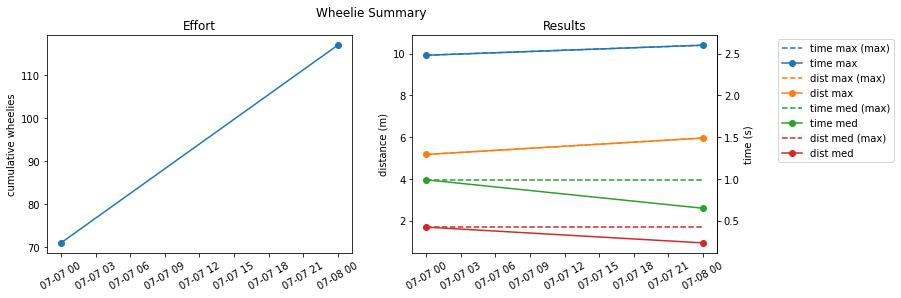

In [21]:
import matplotlib.pyplot as plt

day_grouped = accum.groupby(pd.Grouper(key='datetime', freq='1D'))
groups = day_grouped.groups
for g in groups.copy():
  try:
    day_grouped.get_group(g)
  except:
    groups.pop(g)

gs_data_time = [list(get_summary_time(day_grouped.get_group(g))) for g in groups]
ds_df_time = pd.DataFrame(gs_data_time, columns=['count', 'total time', 'max', 'median'])
gs_data_dist = [list(get_summary_dist(day_grouped.get_group(g))) for g in groups]
ds_df_dist = pd.DataFrame(gs_data_dist, columns=['count', 'total dist', 'max', 'median'])

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle('Wheelie Summary')

ax[0].plot([g for g in groups], ds_df_dist['count'].cumsum(), '-o')
ax[0].set_ylabel('cumulative wheelies')
ax[0].set_title('Effort')
ax[0].tick_params(axis='x', labelrotation=30)

ax[1].plot([g for g in groups], ds_df_time['max'].expanding().max() * 4, '--', color='tab:blue')
ax[1].plot([g for g in groups], ds_df_time['max'] * 4, '-o', color='tab:blue')
ax[1].plot([g for g in groups], ds_df_dist['max'].expanding().max(), '--', color='tab:orange')
ax[1].plot([g for g in groups], ds_df_dist['max'], '-o', color='tab:orange')
ax[1].plot([g for g in groups], ds_df_time['median'].expanding().max() * 4, '--', color='tab:green')
ax[1].plot([g for g in groups], ds_df_time['median'] * 4, '-o', color='tab:green')
ax[1].plot([g for g in groups], ds_df_dist['median'].expanding().max(), '--', color='tab:red')
ax[1].plot([g for g in groups], ds_df_dist['median'], '-o', color='tab:red')
ax[1].legend(['time max (max)', 'time max',
            'dist max (max)', 'dist max',
            'time med (max)', 'time med',
            'dist med (max)', 'dist med'],
           loc='right', bbox_to_anchor=(1.6, 0.7))
ax[1].set_ylabel('distance (m)')
ax[1].set_title('Results')
ax[1].tick_params(axis='x', labelrotation=30)

secaxy = ax[1].secondary_yaxis('right', functions=(lambda x: x / 4, lambda x: x * 4))
secaxy.set_ylabel('time (s)')

plt.show()